In [1]:
%matplotlib inline
import pandas as pd
import librosa as lib
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy

In [2]:
#import demographic information dataframe, includes all participants, but we will only use partiicpant 1 info for now
demos = pd.read_pickle(r'DFs/demos_clean.pkl')

Reminder of what dataframe look like

In [3]:
demos[demos['Group']=='G'].head(15)

,PID,SID,Group,Subject,Age,Sex,Height,Listen,Produce,Dance,Exercise,Tiresome,Exper_silent,Exper_music,Eyes,Knees,Mean QoM,Mean QoM w/oM,Mean QoM w M,NoMus-Mus Diff
54,55,G1,G,1,34,M,1.97,2,0.0,0.5,2.5,3,2.0,1,1.0,0.5,6.378318,6.440756,6.315884,-0.124871
55,56,G2,G,2,16,M,1.75,30,0.0,2.0,20.0,4,3.0,4,0.5,1.0,7.401186,7.058412,7.743941,0.685529
56,57,G3,G,3,16,M,1.81,10,3.0,1.0,9.0,3,3.0,5,1.0,0.5,8.634003,8.130352,9.137627,1.007275
57,58,G4,G,4,16,M,1.74,30,0.0,4.0,15.0,3,4.0,4,1.0,1.0,7.012755,6.351092,7.674381,1.323290
58,59,G5,G,5,57,M,1.74,10,0.0,4.0,5.0,1,2.0,3,1.0,0.5,6.375268,6.495071,6.255472,-0.239599
59,60,G7,G,7,20,F,1.63,40,3.0,3.0,0.0,2,2.0,3,1.0,0.5,4.750186,4.715377,4.784993,0.069616
60,61,G8,G,8,26,F,1.85,40,2.0,2.0,3.0,3,3.0,1,1.0,0.5,5.454202,5.353647,5.554751,0.201104
61,62,G9,G,9,24,M,1.86,2,0.0,2.0,0.0,3,3.0,2,1.0,1.0,5.022963,4.861272,5.184645,0.323372
62,63,G10,G,10,22,M,1.63,25,0.0,0.0,0.0,2,3.0,4,1.0,0.0,4.854129,4.987055,4.721211,-0.265844
63,64,G11,G,11,19,F,1.71,15,12.0,5.0,2.0,4,4.0,3,1.0,1.0,7.241129,7.031658,7.450587,0.418929


In [4]:
# to match with cleaned motion data we need to drop group P and participant 56
demos = demos.loc[demos['Group'] != 'P']
demos['Group'].unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], dtype=object)

In [5]:
demos = demos.loc[demos['PID']!=56]
demos.shape

(73, 20)

This matches with our useable motion data, participants numbered 1-74 with no number 56. AS a reminder, group P didn't have any motion data provided and PID 56 (SID G2) had incomplete motion data (many zero readings)

### Demograhpic EDA

There are number of columns that include questionaire data and motion data that isn't available until after the test is complete. In order to only be using the data which is available at the time the prediction needs to be made we will be dropping the columns that contain this ex-post data

In [6]:
demos_clean = demos.drop(columns=['Group', 'Subject', 'Exper_silent', 'Exper_music', 'Eyes',
       'Knees', 'Mean QoM', 'Mean QoM w/oM', 'Mean QoM w M', 'NoMus-Mus Diff'])

In [7]:
demos_clean['Sex'].replace({'M':0, 'F':1}, inplace=True)
demos_clean

,PID,SID,Age,Sex,Height,Listen,Produce,Dance,Exercise,Tiresome
0,1,A1,23,0.0,1.72,5,30.0,1.0,7.0,3
1,2,A2,24,0.0,1.67,10,10.0,2.0,10.0,1
2,3,A3,27,1.0,1.63,14,1.0,4.0,3.0,4
3,4,A4,27,0.0,1.75,5,20.0,2.0,2.0,4
4,5,A9,24,1.0,1.64,15,0.0,2.0,6.0,2
...,...,...,...,...,...,...,...,...,...,...
69,70,H7,26,0.0,1.72,8,10.0,1.0,4.0,1
70,71,H8,24,0.0,1.71,12,10.0,2.0,7.0,1
71,72,H9,65,1.0,1.73,4,0.0,2.0,2.0,2
72,73,H10,45,1.0,1.67,5,0.0,0.0,3.0,1


In [8]:
demos_clean['age_bin'] = pd.qcut(demos_clean['Age'], 5, labels=range(1,6))
demos_clean['height_bin'] = pd.qcut(demos_clean['Height'], 5, labels=range(1,6))
demos_clean.head()

,PID,SID,Age,Sex,Height,Listen,Produce,Dance,Exercise,Tiresome,age_bin,height_bin
0,1,A1,23,0.0,1.72,5,30.0,1.0,7.0,3,3,2
1,2,A2,24,0.0,1.67,10,10.0,2.0,10.0,1,3,2
2,3,A3,27,1.0,1.63,14,1.0,4.0,3.0,4,4,1
3,4,A4,27,0.0,1.75,5,20.0,2.0,2.0,4,4,3
4,5,A9,24,1.0,1.64,15,0.0,2.0,6.0,2,3,1


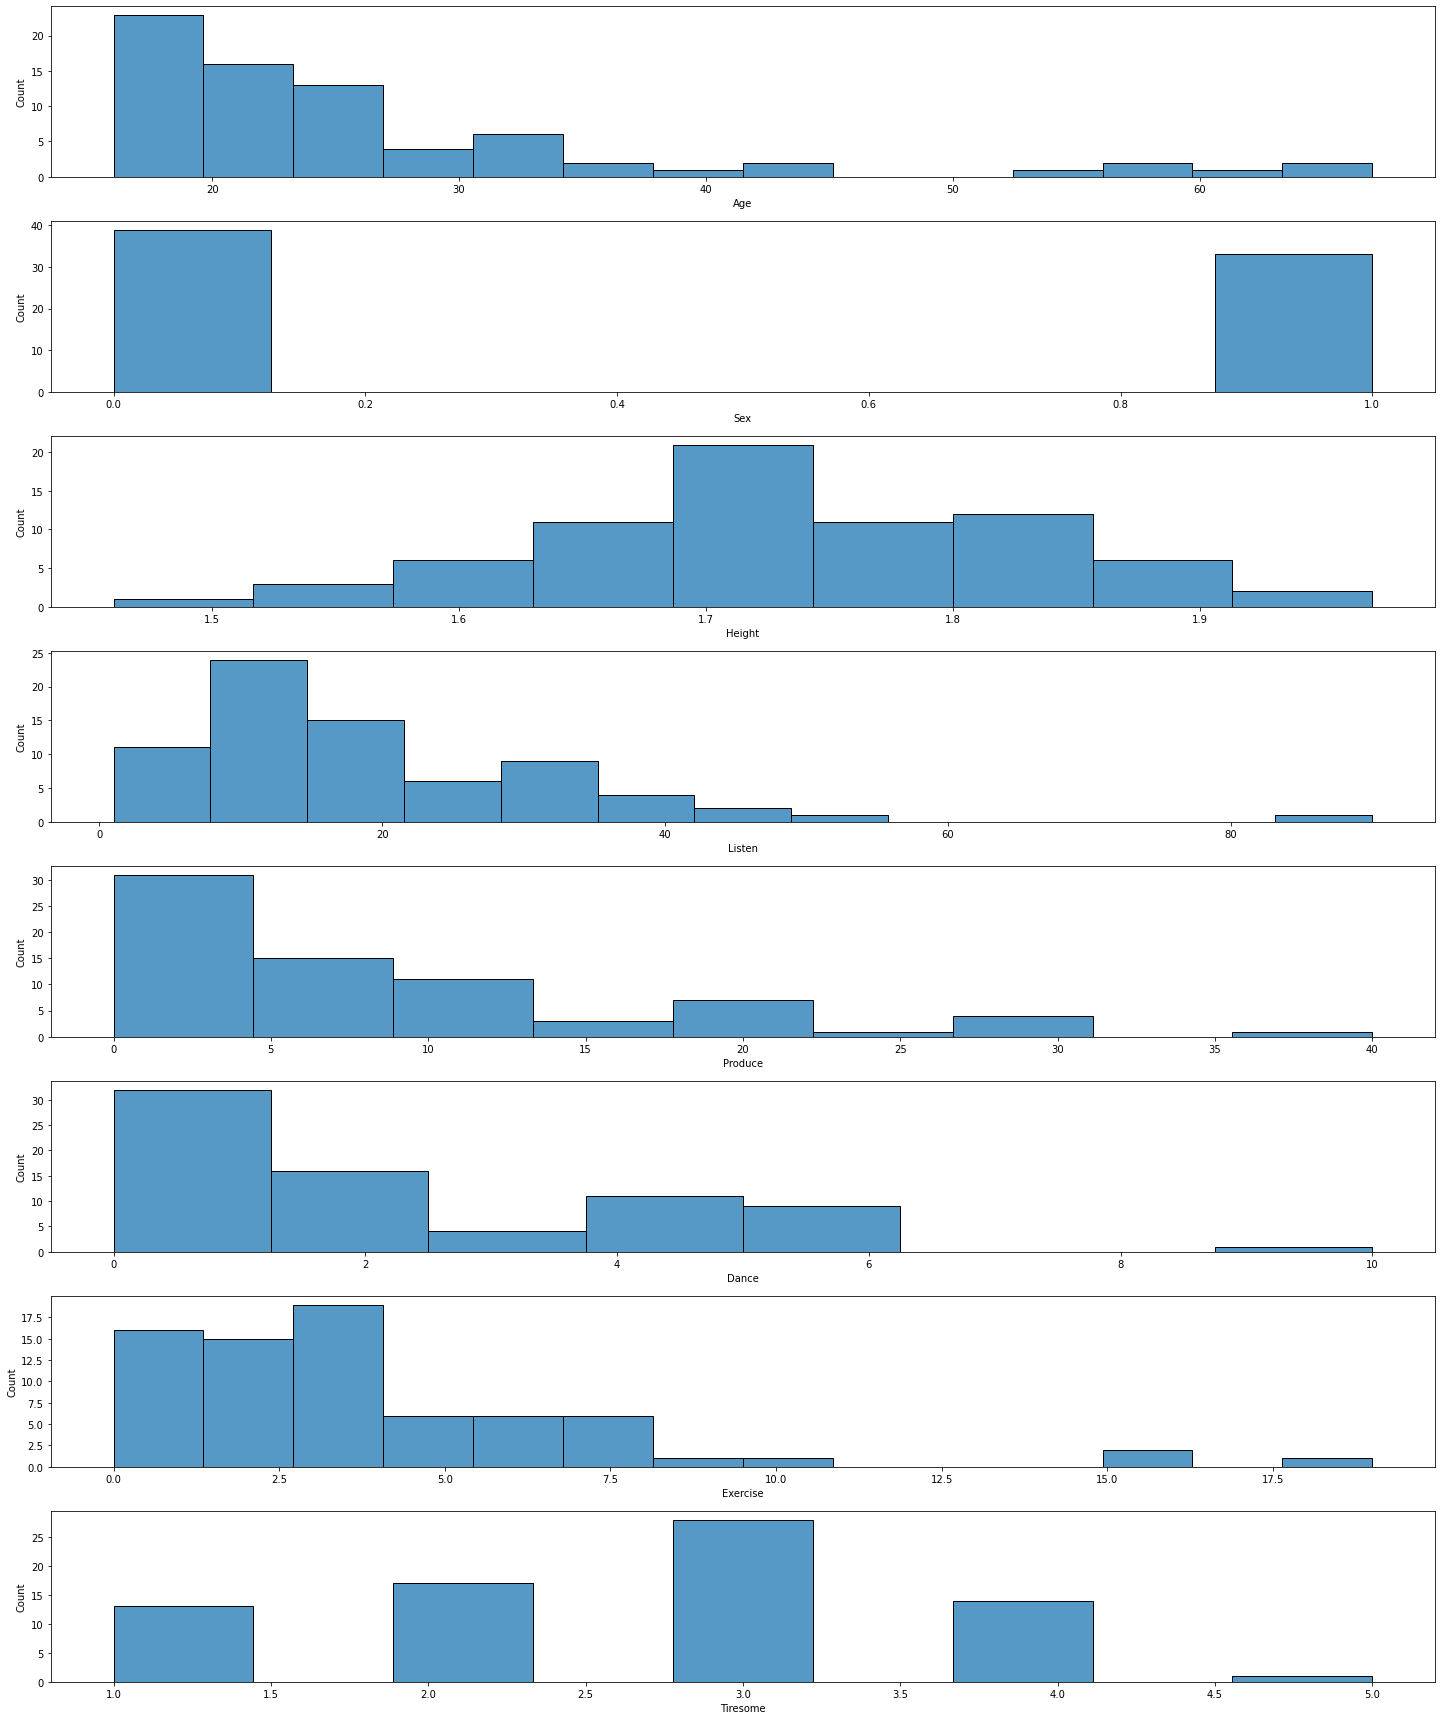

In [9]:
#Plotting the boxplots for each column of the demographics data remaining
columns = list(demos_clean.columns)
fig, axes = plt.subplots(8, 1, figsize=(20, 24))
for col_i in range(2, 10):
    sns.histplot(demos_clean.iloc[:,col_i], ax=axes[col_i - 2])
plt.tight_layout()
plt.show()

In [10]:
demos_clean.describe()

,PID,Age,Sex,Height,Listen,Produce,Dance,Exercise,Tiresome
count,73.000000,73.000000,72.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,37.246575,26.561644,0.458333,1.733836,19.315068,8.143836,2.127397,3.821918,2.630137
std,21.543097,12.110586,0.501757,0.097463,14.472077,9.262934,2.012824,3.578844,1.034231
min,1.000000,16.000000,0.000000,1.460000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,19.000000,19.000000,0.000000,1.670000,10.000000,0.000000,0.300000,2.000000,2.000000
50%,37.000000,23.000000,0.000000,1.730000,15.000000,5.000000,2.000000,3.000000,3.000000
75%,55.000000,27.000000,1.000000,1.800000,25.000000,10.000000,4.000000,5.000000,3.000000
max,74.000000,67.000000,1.000000,1.970000,90.000000,40.000000,10.000000,19.000000,5.000000


### Looking through each boxplot and summary data we can see the following:
- Age - Range from 16 to 67 with the majority in their early to mid twenties
- Sex - Men (0) are slightly more prevelent at just over 54%
- Height - ranges from 1.55m (5'1") to 1.97m (6'6") with a slight outlier at the bottom at 1.46m (4'10"), interquartile range runs from 1.67m (5'6") to 1.80m (5'11")
- Listen - Most participant fall within a grouping from 10 to 30 hours, while one upper outlier stated 80+ hours
- Produce - Most participants fall within a grouping from 0 to 10 hours, while two upper outliers exist at 30 and 40 hours
- Exercise - While this is affected by how much overall exercise a person performs it does follow the pattern of the last two categories where a strong grouping exists at 2 to 5 hours and a few outliers exist on the upper bound
- Tiresome - This was rated on a 1 to 5 (1:Tiring, 5:Not Tiring) and the distributiuon shows people tend towards small effect with a lean towards not tiring

In [11]:
#Taking a look at the difference between the smallest height and the 2nd smallest
demos_clean['Height'].sort_values()

38    1.46
37    1.55
27    1.57
22    1.57
52    1.59
      ... 
42    1.88
21    1.89
6     1.91
18    1.93
54    1.97
Name: Height, Length: 73, dtype: float64

In [1]:
#The females appear slightly older than the male particpants, though it is a small dataset
sns.histplot(data=demos_clean, x='Age', hue='Sex', common_bins=False, palette='Set2', multiple='dodge')
plt.legend({'Male':0, 'Female':1})
plt.show()

NameError: name 'sns' is not defined

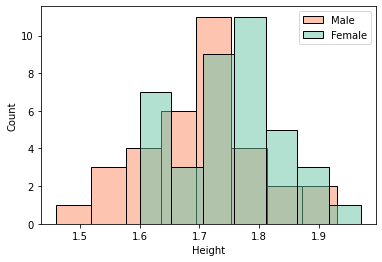

In [13]:
#The males appear slightly taller than the females overall which is typically expected
sns.histplot(data=demos_clean, x='Height', hue='Sex', common_bins=False, palette='Set2', legend=False, multiple='dodge')
plt.legend({'Male':0, 'Female':1})
plt.show()

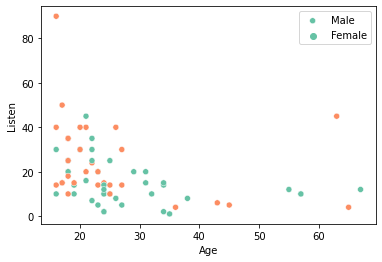

In [14]:
sns.scatterplot(data=demos_clean, x='Age', y='Listen', hue='Sex', palette='Set2')
plt.legend({'Male':0, 'Female':1})
plt.show()

It appears that there is a correlation between age and how much music is listened too. It does not appear that the is significant coorelation between sex and amount of music listened to.

It's worthwhile to take a look at a visualization of the correlation across these factors throuhg seaborn's heatmap function.

In [15]:
demo_corr = demos_clean.corr()

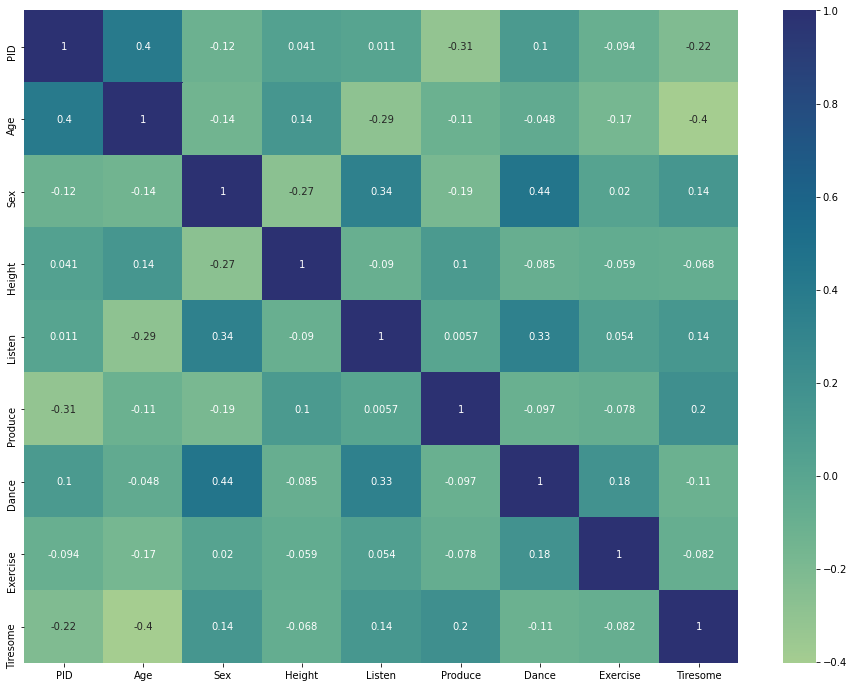

In [16]:
plt.figure(figsize=(16, 12))
sns.heatmap(demo_corr, cmap='crest', annot=True)
plt.show()

None of the variables appear top have strong correlations to each other.

In [17]:
#Exporting the Demographic information with the ex-post variables removed
demos_clean.to_pickle('DFs/demos_EDA.pkl')